### Идея решения:
Задача состоит в том, чтобы отделить изображения, содержащие категорию, от всех остальных изображений.
Предлагается с помощью ResNet50 извлечь вектор признаков из каждого изображения, отмасштабировать, уменьшить размерность признакового пространства с помощью PCA, а затем использовать алгоритм одноклассовой классификации OneClassSVM. 
Так как крайне кричитно не иметь ошибок в положительном принятии решений и менее критично упущение некоторых случаев, для которых есть отдел мониторинга, необходимо, чтобы при классификации была высокая точность (precision). Поэтому, в качестве метрики возьмем fbeta_score с параметром beta = 0.5.

In [1]:
import torch
from torch.utils.data import Dataset, random_split
from torchvision import datasets, transforms, models
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, fbeta_score, make_scorer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
from skimage import io
import shutil 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

### Подготовка данных
Разобьем все имеющиеся данный на обучающую, валидационную и тестовую выборки. В обучающей выборке будут только примеры, содержащие какую либо категорию.

In [2]:
bags_dir = 'CategoryData/Bags/'
sneakers_dir = 'CategoryData/Sneakers/'
speakers_dir = 'CategoryData/Speakers/'
others_dir = 'CategoryData/Others/'

In [3]:
bags_paths = [os.path.join(bags_dir, img_name) for img_name in os.listdir(bags_dir)]
sneakers_paths = [os.path.join(sneakers_dir, img_name) for img_name in os.listdir(sneakers_dir)]
speakers_paths = [os.path.join(speakers_dir, img_name) for img_name in os.listdir(speakers_dir)]
others_paths = [os.path.join(others_dir, img_name) for img_name in os.listdir(others_dir)]

train_bags_paths, test_bags_paths = train_test_split(bags_paths, test_size = 0.25)
train_sneakers_paths, test_sneakers_paths = train_test_split(sneakers_paths, test_size = 0.25)
train_speakers_paths, test_speakers_paths = train_test_split(speakers_paths, test_size = 0.25)

train_bags_paths, val_bags_paths = train_test_split(train_bags_paths, test_size = 0.25)
train_sneakers_paths, val_sneakers_paths = train_test_split(train_sneakers_paths, test_size = 0.25)
train_speakers_paths, val_speakers_paths = train_test_split(train_speakers_paths, test_size = 0.25)

val_others_path, test_others_path = train_test_split(others_paths, test_size = 0.3)

In [4]:
val_category_paths = val_bags_paths+val_sneakers_paths+val_speakers_paths
test_category_paths = test_bags_paths+test_sneakers_paths+test_speakers_paths

train_paths = shuffle(train_bags_paths+train_sneakers_paths+train_speakers_paths)
val_paths = shuffle(val_category_paths+val_others_path)
test_paths = shuffle(test_category_paths+test_others_path)

На вход в ResNet50 подаются RGB изображения размера 224 $\times$ 224. Поэтому, если среди данных есть черно-белое изображение, его нужно сделать 3-канальным.

In [5]:
class My_Dataset(Dataset):
    def __init__(self, img_paths, transform = None):
        self.img_paths = img_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = io.imread(self.img_paths[idx]) 
        
        if len(image.shape) != 3:
            image = Image.fromarray(image, mode = 'L')
            image = Image.merge('RGB', (image, image, image))
        else:
            image = Image.fromarray(image, mode = 'RGB')
           
        if self.transform:
            image = self.transform(image)
        
        return image

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
X_train = My_Dataset(train_paths, transform=transform)
X_val = My_Dataset(val_paths, transform=transform)
X_test = My_Dataset(test_paths, transform=transform)

In [8]:
y_val = [1 if path in val_category_paths else 0 for path in val_paths]
y_test = [1 if path in test_category_paths else 0 for path in test_paths]

Посмотрим на изображения в валидационной выборке.

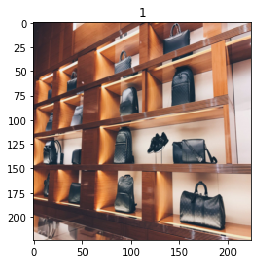

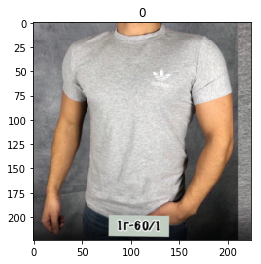

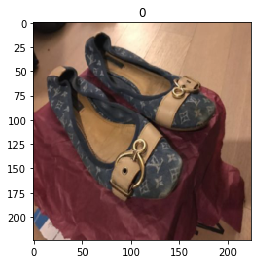

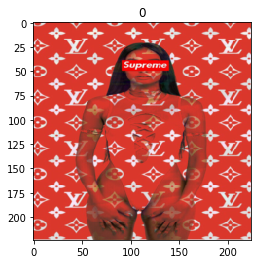

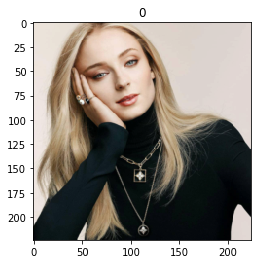

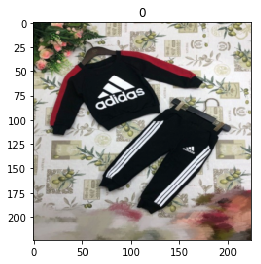

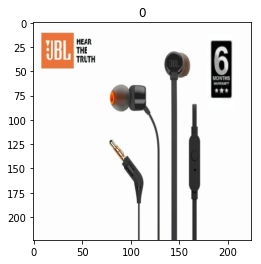

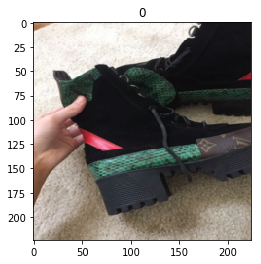

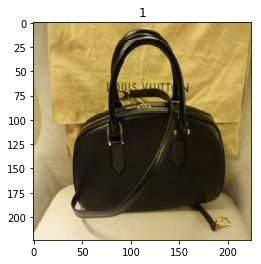

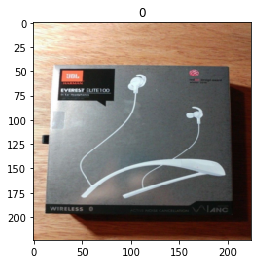

In [9]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i in range(10):
    plt.imshow((X_val[i].permute(1, 2, 0).numpy() * std + mean).clip(0,1))
    plt.title(y_val[i]) # 1-на изображении есть категория, 0 - нет категории
    plt.show()
    plt.pause(0.001)

### Извлечение вектора признаков
Используем ResNet50 без последнего подносвязного слоя. Каждому изображению будет соответствовать вектор размера 2048.

In [9]:
model = models.resnet50(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
n_output = 2048
def get_vector(img):
    sample = img.unsqueeze(0)
    my_embedding = torch.zeros(1, n_output, 1, 1)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    h = layer.register_forward_hook(copy_data)
    with torch.set_grad_enabled(False):
        model(sample)
    h.remove()
    return my_embedding.numpy()[0, :, 0, 0]

In [11]:
X_train = [get_vector(image) for image in tqdm(X_train)]
X_val = [get_vector(image) for image in tqdm(X_val)]
X_test = [get_vector(image) for image in tqdm(X_test)]

100%|██████████| 1200/1200 [06:19<00:00,  2.81it/s]


### Scaling and PCA
Чтобы уменьшить признаковое пространство отмасштабируем данные и применим метод главных компоненет.

In [12]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scale = ss.transform(X_train)
X_test_scale = ss.transform(X_test)
X_val_scale = ss.transform(X_val)

In [13]:
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train_scale)
print('Explained variance percentage = {:.2f}'.format(sum(pca.explained_variance_ratio_)))

X_train = pca.transform(X_train_scale)
X_test = pca.transform(X_test_scale)
X_val = pca.transform(X_val_scale)

Explained variance percentage = 0.97


### OneClassSVM
Подберем параметры gamma и nu для одноклассового SVM.

In [15]:
gammas = [1e-4, 0.001, 0.1, 'auto']
nus = np.linspace(0.1, 0.5, 5)
for gamma in gammas:
    for nu in nus:
        clf = svm.OneClassSVM(gamma=gamma, nu=nu)
        clf.fit(X_train)
        preds = clf.predict(X_val)
        preds = [0 if p==-1 else 1 for p in preds]
        print('gamma: {}, nu: {}'.format(gamma, nu))
        print('score: {}\n'.format(fbeta_score(y_val, preds, beta=0.5)))

gamma: 0.0001, nu: 0.1
score: 0.6615886833514688

gamma: 0.0001, nu: 0.2
score: 0.7074158440901039

gamma: 0.0001, nu: 0.30000000000000004
score: 0.7354221061792863

gamma: 0.0001, nu: 0.4
score: 0.7455994686150782

gamma: 0.0001, nu: 0.5
score: 0.7460378817162738

gamma: 0.001, nu: 0.1
score: 0.6628084734658222

gamma: 0.001, nu: 0.2
score: 0.710292249047014

gamma: 0.001, nu: 0.30000000000000004
score: 0.7368726428778649

gamma: 0.001, nu: 0.4
score: 0.7449285001662788

gamma: 0.001, nu: 0.5
score: 0.7460378817162738

gamma: 0.1, nu: 0.1
score: 0.11258278145695363

gamma: 0.1, nu: 0.2
score: 0.1797175866495507

gamma: 0.1, nu: 0.30000000000000004
score: 0.199252801992528

gamma: 0.1, nu: 0.4
score: 0.17419354838709677

gamma: 0.1, nu: 0.5
score: 0.19695044472681067

gamma: auto, nu: 0.1
score: 0.6725407093464197

gamma: auto, nu: 0.2
score: 0.7144692881007454

gamma: auto, nu: 0.30000000000000004
score: 0.7385200350979818

gamma: auto, nu: 0.4
score: 0.7442557442557443

gamma: auto, 

In [16]:
oc_svm_clf = svm.OneClassSVM(gamma='auto')
oc_svm_clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [17]:
oc_svm_preds = oc_svm_clf.predict(X_test)
oc_svm_preds = [0 if x == -1 else 1 for x in oc_svm_preds]

In [18]:
print('fbeta_score = {}'.format(fbeta_score(y_test, oc_svm_preds, beta=0.5)))

fbeta_score = 0.8080985915492958


In [19]:
print('precision_score = {}'.format(precision_score(y_test, oc_svm_preds)))

precision_score = 0.9386503067484663


In [20]:
svm_results = pd.DataFrame({
    'path' : test_paths,
    'oc_svm_preds' : oc_svm_preds,
    'is_category' : y_test
})
svm_results.head()

,path,oc_svm_preds,is_category
0,CategoryData/Bags/z3o6RbQyKT7AQpm.jpg,1,1
1,CategoryData/Sneakers/wZ5odvBCyPFjJUq.jpg,1,1
2,CategoryData/Sneakers/5XHVPhDljFBR3nf.jpg,0,1
3,CategoryData/Sneakers/EQj3yugZRNuskXL.jpg,0,1
4,CategoryData/Speakers/asUtfijEHi6Ef3O.jpg,1,1


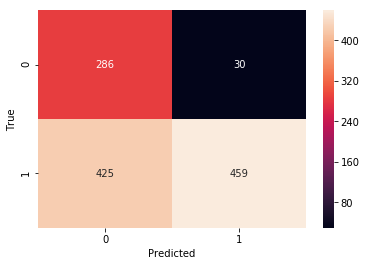

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, oc_svm_preds),annot=True,fmt='2.0f')
plt.xlabel('Predicted')
plt.ylabel("True")
plt.show()

Получилось относительно немного False Positive ответов, что хорошо в нашей задаче. Однако очень много False Negative.
Посмотрим, в каких случаях модель ошибается при положительном ответе:

CategoryData/Others/oF468jPX8h04JHs.jpg
oc_svm_preds: 1 | actual: 0


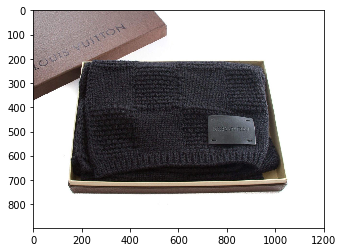

CategoryData/Others/LvNpp2W8oABZAzN.jpg
oc_svm_preds: 1 | actual: 0


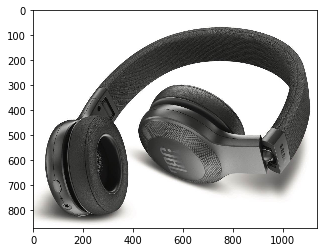

CategoryData/Others/EI1IFqIjeIQ75km.jpg
oc_svm_preds: 1 | actual: 0


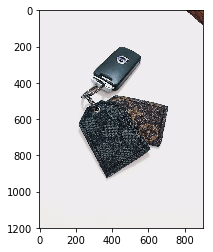

CategoryData/Others/0a3abf1d-e0c5-40b5-bd9c-e17de4147722.jpg
oc_svm_preds: 1 | actual: 0


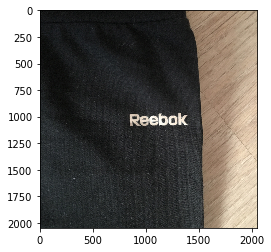

CategoryData/Others/V2MDzMmpEexh1il.jpg
oc_svm_preds: 1 | actual: 0


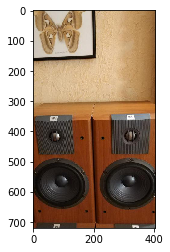

CategoryData/Others/zVCwevshMDsn4ti.jpg
oc_svm_preds: 1 | actual: 0


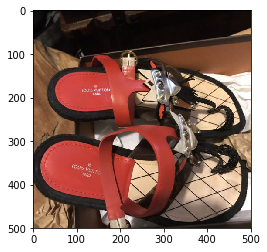

CategoryData/Others/jf9SRvYbtwDWGhA.jpg
oc_svm_preds: 1 | actual: 0


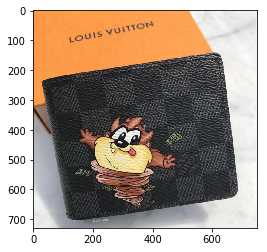

CategoryData/Others/T37jPOqvNCdoi87.jpg
oc_svm_preds: 1 | actual: 0


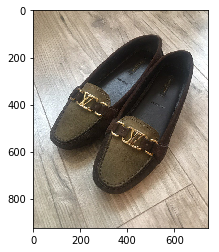

CategoryData/Others/tjP2Qi9vVyfqCTb.jpg
oc_svm_preds: 1 | actual: 0


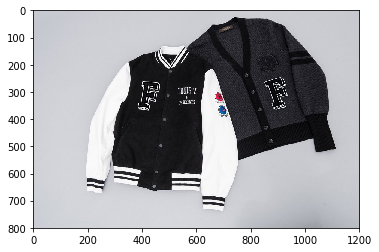

CategoryData/Others/O3YDoCqeHo2ZSyI.jpg
oc_svm_preds: 1 | actual: 0


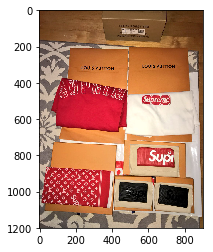

CategoryData/Others/jxlZgVXeh4IDTN6.jpg
oc_svm_preds: 1 | actual: 0


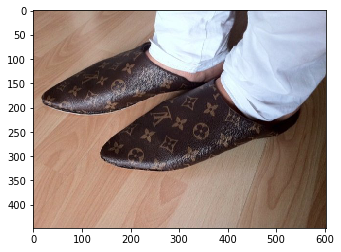

CategoryData/Others/wEF7A60ZWiQWFAN.jpg
oc_svm_preds: 1 | actual: 0


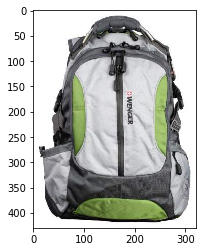

CategoryData/Others/AgPKXWrkBPQ.jpg
oc_svm_preds: 1 | actual: 0


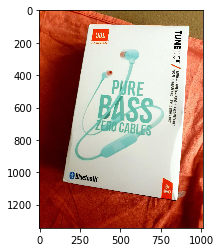

CategoryData/Others/ziRiNpV2wai78TY.jpg
oc_svm_preds: 1 | actual: 0


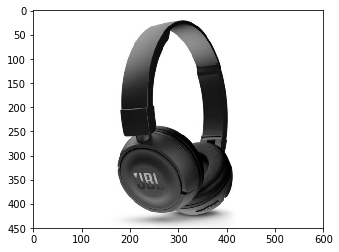

CategoryData/Others/tdrcHdKiharsoH7.jpg
oc_svm_preds: 1 | actual: 0


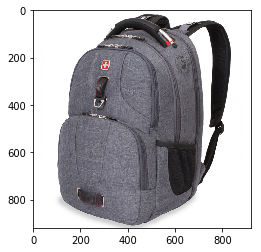

CategoryData/Others/zRl0jjBX9xFLnQT.jpg
oc_svm_preds: 1 | actual: 0


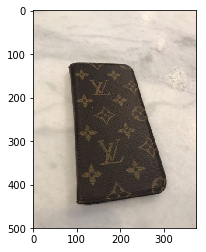

CategoryData/Others/r1oTF3wbO4j7AHp.jpg
oc_svm_preds: 1 | actual: 0


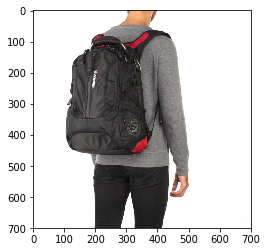

CategoryData/Others/0X3ydvXnj0m3Vd1.jpg
oc_svm_preds: 1 | actual: 0


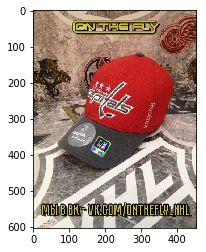

CategoryData/Others/S0cDtogBpjeqjIh.jpg
oc_svm_preds: 1 | actual: 0


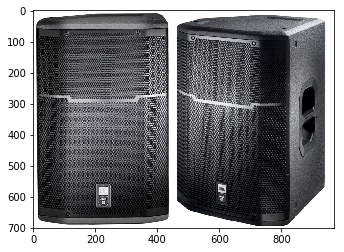

CategoryData/Others/G7nODZJXiGvDIDO.jpg
oc_svm_preds: 1 | actual: 0


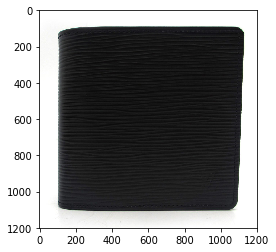

CategoryData/Others/605Loca3E0hSjdr.jpg
oc_svm_preds: 1 | actual: 0


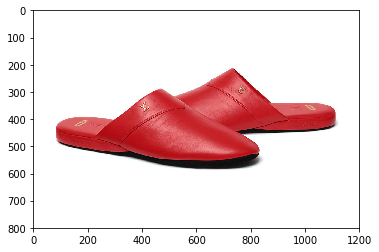

CategoryData/Others/983lGObUFjs4avE.jpg
oc_svm_preds: 1 | actual: 0


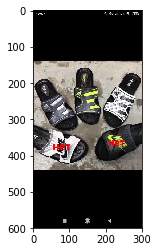

CategoryData/Others/vWm3Ixkp2rQJxdk.jpg
oc_svm_preds: 1 | actual: 0


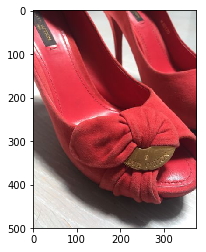

CategoryData/Others/zgNC5oEVz0JWYSw.jpg
oc_svm_preds: 1 | actual: 0


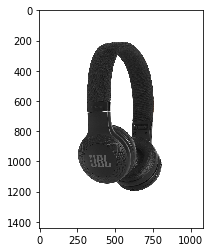

CategoryData/Others/dp7zkyzf5kQou3X.jpg
oc_svm_preds: 1 | actual: 0


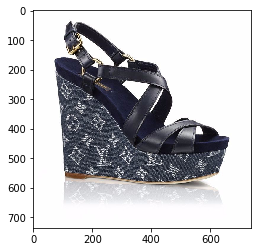

CategoryData/Others/of7IdTIAwXSzstc.jpg
oc_svm_preds: 1 | actual: 0


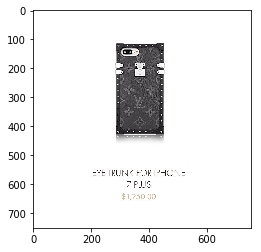

CategoryData/Others/lbthJTnA0bYtYC0.jpg
oc_svm_preds: 1 | actual: 0


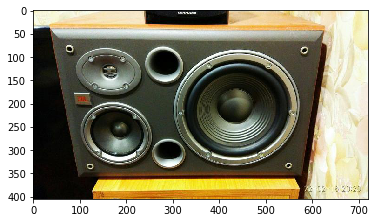

CategoryData/Others/Tvk6f183OmX6pTJ.jpg
oc_svm_preds: 1 | actual: 0


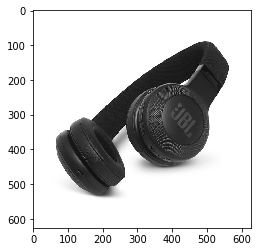

CategoryData/Others/AnzTLyI7g1sSJgg.jpg
oc_svm_preds: 1 | actual: 0


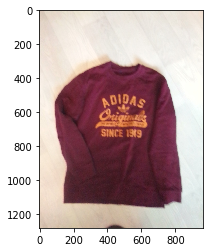

CategoryData/Others/bHegG44aMMzBFXY.jpg
oc_svm_preds: 1 | actual: 0


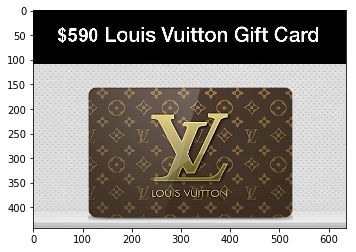

In [23]:
from IPython.display import Image, display
for index, row in svm_results[svm_results['oc_svm_preds']!=svm_results['is_category']].iterrows():
    if row['oc_svm_preds']==1:
        print(row['path'])
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_category']))
        image = io.imread(row['path'])
        plt.imshow(image)
        plt.pause(0.001)

Видим, что есть в папке "Others" существуют изображения, на которых на самом деле присутствует категория (ошибка разметчиков). Таких примеров, как видно выше, как минимум 6. С этим учетом, точность классификатора увеличилась бы почти на 1.5%. 

### Gaussian Mixture:
Еще один способ решения этой задачи. Метод score_samples(X) возвращает логарифм значения плотности вероятности для каждого элемента в выборке Х. Нужно преобразовать эти значения в "оценки вероятности" того, что элемент выборки принадлежит распределению Гаусса. Сделаем это с помощью модели Isotonic regression.

In [24]:
gmm_clf = GaussianMixture(covariance_type='full', n_components=3, max_iter=int(1e7))  
gmm_clf.fit(X_train)
log_probs_val = gmm_clf.score_samples(X_val)
isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
isotonic_regressor.fit(log_probs_val, y_val) 

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None)

In [25]:
log_probs_test = gmm_clf.score_samples(X_test)
test_probabilities = isotonic_regressor.predict(log_probs_test)

In [26]:
gmm_preds = [1 if prob >= 0.5 else 0 for prob in test_probabilities]

In [27]:
print('fbeta_score = {}'.format(fbeta_score(y_test, gmm_preds, beta=0.5)))

fbeta_score = 0.853021978021978


In [28]:
print('precision_score = {}'.format(precision_score(y_test, gmm_preds)))

precision_score = 0.9013062409288825


In [29]:
gmm_results = pd.DataFrame({
    'path': test_paths,
    'gmm_preds': gmm_preds,
    'is_category' : y_test
})

gmm_results.head()

,path,gmm_preds,is_category
0,CategoryData/Bags/z3o6RbQyKT7AQpm.jpg,1,1
1,CategoryData/Sneakers/wZ5odvBCyPFjJUq.jpg,1,1
2,CategoryData/Sneakers/5XHVPhDljFBR3nf.jpg,0,1
3,CategoryData/Sneakers/EQj3yugZRNuskXL.jpg,1,1
4,CategoryData/Speakers/asUtfijEHi6Ef3O.jpg,1,1


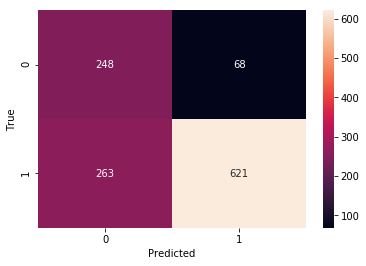

In [30]:
sns.heatmap(confusion_matrix(y_test, gmm_preds),annot=True,fmt='2.0f')
plt.xlabel('Predicted')
plt.ylabel("True")
plt.show()

Здесь видим, что False Negative ответов стало намного меньше, однако возросло относительное количество ошибок при положительном ответе, чего бы нам не хотелось.

### Немного выводов:
Задача интересная, раньше я с такой не сталкивалась. Получились неплохие метрики, но есть предположения, что они могли получится лучше, если бы не неточности в разметке изображений, на которых не должно быть категорий (например, изображения рюкзаков или кошельков).